### Imports

In [19]:
from glob import glob
from scipy.ndimage import label
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import os

### Functions

In [20]:
def crop_connected_regions(mask, vals, cropsize=10):
    labeled_mask, num_labels = label(mask, structure=np.ones((3, 3, 3)))

    cropped_regions = []
    cropped_masks = []

    for region_label in range(1, num_labels+1):
        coords = np.argwhere(labeled_mask == region_label)

        centroid = np.mean(coords, axis=0)

        centroid = np.round(centroid).astype(int)

        half_cropsize = cropsize // 2
        submask = mask[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]
        subvals = vals[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]

        cropped_regions.append(subvals)
        cropped_masks.append(submask)

    return cropped_regions, cropped_masks

In [21]:
def count_voxels(seg, vals=None):
    counts = {}
    means = {}
    stds = {}

    for label_id in np.unique(seg):
        if label_id == 0: continue
        labels, num_labels = label(
            seg * np.array((seg == label_id), int),
            structure=np.ones((3, 3, 3))
        )

        region_counts = []
        region_means = []
        region_stds = []
        for i in range(1, num_labels+1):
            mask = (labels == i)
            region_counts.append(np.sum(mask))
            region_means.append(np.mean(vals[mask]))
            region_stds.append(np.std(vals[mask]))

        counts[label_id] = region_counts
        means[label_id] = region_means
        stds[label_id] = region_stds

    return counts if not vals is not None else counts, means, stds

In [22]:
def update_dict(original_dict, other_dict):
    for key in original_dict:
        if key in other_dict:
            original_dict[key].extend(other_dict[key])
        else:
            original_dict[key] = other_dict[key]
    return original_dict

### Load data

In [23]:
segmentations = glob("bids/sub-*/ses-*/extra_data/*seg*clean.nii*")
qsms = glob("bids/sub-*/ses-*/extra_data/*qsm.nii*")

seed_sizes = []
seed_means = []
seed_stds = []
seed_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []
for i in range(len(segmentations)):
    mask = nib.load(segmentations[i]).get_fdata()
    qsm = nib.load(qsms[i]).get_fdata()
    counts, means, stds = count_voxels(mask, qsm)
    connected_regions_vals, connected_regions_masks = crop_connected_regions(mask == 2, qsm, cropsize=20)
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([segmentations[i] for x in range(len(connected_regions_vals))])
    seed_sizes.extend(counts[2])
    seed_means.extend(means[2])
    seed_stds.extend(stds[2])
    seed_segmentations.extend(os.path.split(segmentations[i])[1] for x in range(len(counts[2])))
data = {"size": seed_sizes, "mean": seed_means, "std": seed_stds, "file" : seed_segmentations}
df = pd.DataFrame(data).sort_values("size")

### Visualise data

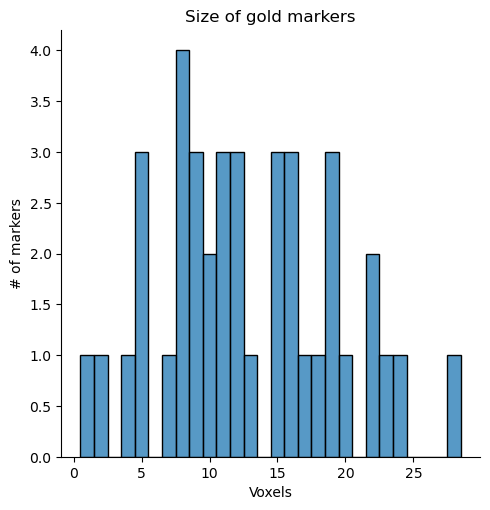

In [24]:
sns.displot(data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of markers")
plt.title("Size of gold markers")
plt.savefig("seed_size_histogram.png", bbox_inches='tight')
plt.show()

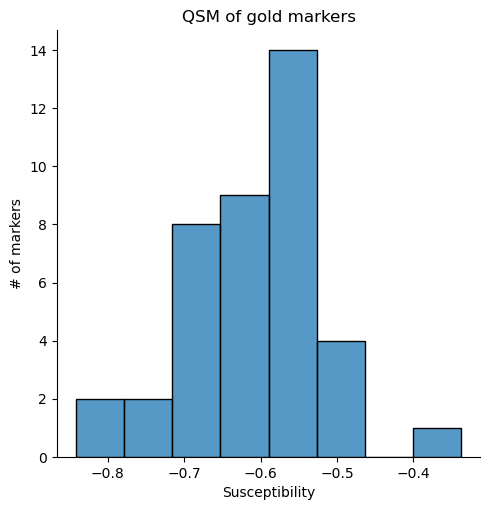

In [25]:
sns.displot(data, x='mean')
plt.xlabel("Susceptibility")
plt.ylabel("# of markers")
plt.title("QSM of gold markers")
plt.savefig("seed_qsm_histogram.png", bbox_inches='tight')
plt.show()

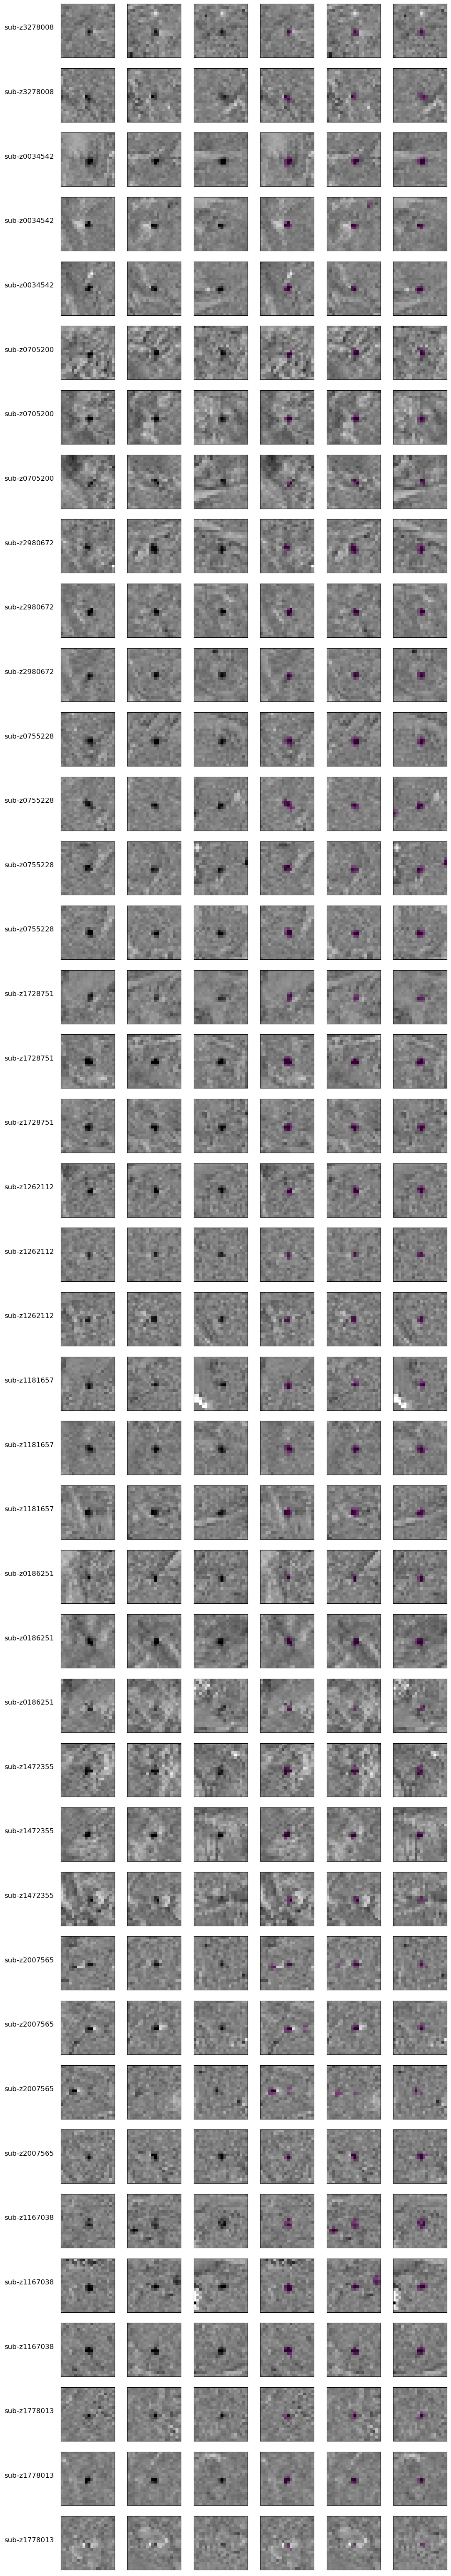

In [26]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(regions_vals)):
    axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)

    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds.png", bbox_inches='tight')
plt.show()
plt.close()

In [27]:
#fig.savefig('ax2_figure.png', bbox_inches=extent)